# 1) Notes: 

## THERE IS A "BUMP" IN MANTLE TEMPERATURE AT LATE TIMES WHEN USING THE EQUATION FOR Q(TAU_HEAT) FROM THE PAPER (I.E., tau_decay/(rho_m * c_p * T_ref/Q_0) INSTEAD OF THE SMOOTH EVOLUTION OF MANTLE TEMPERATURE IN TAD'S CODE USING (tau_decay/(rho_m * c_p * T_ref/F_0). COULD THIS BUMP BE REAL??? WHY DOES CHANGING THE NON-DIMENSIONAL TIMESCALE CAUSE THIS?
## --> INTERESTINGLY, THIS ONLY REMOVES THE BUMP WHEN THE TIMESCALE IS CHANGED IN THE EXPONENTIAL, WHILE THE REST OF THE EQUATION IS THE SAME AS IN THE PAPER. (XXXX IS THIS ACTUALLY HAPPENING? TEST THESE VALUES AGAIN LATER XXXX)

## ACCORDING TO TAD, REGASSING CHECK IS "WONKY" -- FIGURE OUT A BETTER WAY TO DO THIS IN SIMPLE ANALYTIC MODEL (OR USE A MORE COMPLICATED MODEL, I.E. LAURA'S)

# 2) XXXX Things to vary, once code runs with loss XXXX
## - total initial water [a) surface, b) interior]
## - water loss [c) rate, d) timescale]
## -- *Sensitivity Analysis*

# 3) XXXX Code Improvements XXXX
## - Laura's code
## - Better atmospheric loss (diffusion-limited escape; as opposed to energy-limited); accounting for planetary climate, atmospheric composition; wind-driven --> magnetic field --> mantle convection --> dynamo in outer core; hydrogen-generation --> photolysis of water and methane (our assumptions for now), OR serpentinization if iron-rich rock
## - Convection speed and regassing efficiency

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Need to divide constants into three categories --
# XXXX SEE OTHER RECODED NOTEBOOK FOR DESCRIPTIONS OF ALL CONSTANTS XXXX

# 1) Unchanging constants
# [M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry]

params1 = np.loadtxt('const_params.txt')
M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1

# 2) Varied parameters
# [x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
#  T_serp, K_cnst, gamma, r_fug, d_b]

params2 = np.loadtxt('vary_params.txt')
x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
     T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2

# 3) Changing parameters
# [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]

params3 = np.loadtxt('change_params.txt')
omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3

In [3]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x_twid, params1, params2, params3): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid*omega_0*f_btwid/f_M
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_wtwid(x_twid, params1, params2, params3):
    
    return np.exp(lnf_w(x_twid, params1, params2, params3)) / (np.exp(lnf_w(1., params1, params2, params3)))

In [4]:
#print((np.exp(lnf_w(1., params1, params2, params3))))

In [5]:
## MANTLE VISCOSITY

# Need a function to calculate the viscosity.
def eta(T_twid, x_twid, params1, params2, params3): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600. #[K]
    
    f_w = np.exp(lnf_w(x_twid,params1,params2,params3)) #lnf_w needs non-dimensionalized x
    
    # Need a minimum fugacity, to avoid f_w --> 0 and eta --> infinity.
    if f_w > f_w_min:
        return eta_0 * (f_w**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))
    elif f_w <= f_w_min:
        return eta_0 * (f_w_min**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))

In [6]:
#print(eta(0.5,1.,params1,params2,params3))

In [7]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def gtwid(M): #dimensionless gravity, normalized to Earth (FOR NOW)
    return g(M)/9.8

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(1.,params1,params2,params3))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(T_twid, x_twid, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid * omega_0 * f_btwid / f_M # mantle water mass fraction
    T = T_twid * T_ref #[K]
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*(T-T_s)/(eta(T_twid,x_twid,params1,params2,params3)*Ra_c))**(2.*beta))

def tau(M, params1, params2, params3): #useful for converting between different non-dimensional timescales
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

def tau_decay_twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return 2.0e9*year/(rho_m*c_p*T_ref/F_0(M,params1,params2,params3))
    # return 2.0e9*3.154e7/(rho_m*c_p*T_ref/Q_0) #TEST Q_0 against F_0 in taudecay

def F_0twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return F_0(M,params1,params2,params3)/Q_0

def Ra(T_twid, x_twid, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return (alpha*rho_m*g(M)*(T_twid*1600. - T_s)*(h(M)**3))/(eta(T_twid, x_twid, params1, params2, params3)*kappa)

In [8]:
# Things that need to be calculated with constants and above functions:
omg_Etwid = num_oceans*omega_E/omega_0
omegatwid = omg_Etwid/(f_btwid)
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/E_a
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref
Ktwid = K_cnst/T_ref
Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
eta_0 = 1.e21/eta_scale
f_w = np.exp(lnf_w(1.,params1,params2,params3))
f_wtwid_min = f_w_min/np.exp(lnf_w(1.,params1,params2,params3)) #CONSERVATIVELY CHOSEN AS 1e-5 FOR NOW
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
#tau_heat = Q_0/(rho_m*c_p*T_ref)

# 4) Calculated parameters
params4 = [omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E]

In [9]:
print(loss_factor*(L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year*(1e9/1.4e21))

3.3292952411594943


# CA Model, using scipy.integrate --> GOOD! LOSS INCLUDED!
## scipy.optimize, with the integrator option 'vode', seems to be the best for this.

In [10]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

def f_delta_temp_CA(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum fugacity, to avoid f_wtwid --> 0 and eta --> infinity.  
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
            dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
        else:
            dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
        else:
            rg_CA = (d_b/d_hE)
        
        dx_twid = rg_CA - dg_CA
        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            dx_twid = ((gtwid(M)**2.)*s_twid)**sigma - 0.
        else:
            dx_twid = (d_b/d_hE) - 0. 
            
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        
        dx_twid = 0. - (Xtwid**-1.)*x_twid*(1./f_degasE) #from degassing check from CA2014 paper, or else degas blows up
    
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    else: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Leaving the above loss factor (in params) will cause exponential loss.
    #loss_factor = 0. # This will turn off the atmospheric loss.
    loss_factor = 10.*loss_factor #EXTREME LOSS -- WILL THE CODE WORK????
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        # Degassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
            dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
        else:
            dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
        else:
            rg_CA = (d_b/d_hE)
        
        ds_twid = dg_CA - rg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            ds_twid = 0. - ((gtwid(M)**2.)*s_twid)**sigma - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        else:
            ds_twid = 0. - (d_b/d_hE) - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing or lose if no water on surface
        
        ds_twid = (Xtwid**-1.)*x_twid*(1./f_degasE) - 0. - 0. #from degassing check from CA2014 paper, or else degas blows up
        
        # Surface water capacity check
        if s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
    
    else: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_CA(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_CA(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                f_delta_x_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                f_delta_s_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4)]

In [11]:
### Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Regassing check from CA2014
    if s_twid > 0. and ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE): #normal regassing
        return ((gtwid(M)**2.)*s_twid)**sigma
    elif s_twid > 0. and ((gtwid(M)**2.)*s_twid)**sigma >= (d_b/d_hE):
        return (d_b/d_hE)
    else: #if s_twid <= 0; no regassing
        return 0.
    
def f_degas_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Degassing check from CA2014
    if x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE): #normal degassing
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    elif x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) >= (1./f_degasE):
        return (Xtwid**-1.)*x_twid*(1./f_degasE)
    elif x_twid > 0. and s_twid <= 0.:
        return (Xtwid**-1.)*x_twid*(1./f_degasE)
    else: #if x_twid <= 0. OR s_twid <=0 ; no degassing --> depends on seafloor pressure, no water = no pressure
        return 0.
    
def f_loss_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Leaving the above loss factor will cause exponential loss.
    #loss_factor = 0. # This will turn off the atmospheric loss.
    loss_factor = 10.*loss_factor # EXTREME LOSS -- WILL THE CODE WORK???
    
    # OPTION 1: SEE FIGURE
    #if s_twid > 0.: #normal loss
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #else: #if s_twid <= 0; no loss
    #    return 0.
    
    if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
        dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    else:
        dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
    #Regassing check from CA2014 paper
    if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
        rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
    else:
        rg_CA = (d_b/d_hE)
        
    ds_twid = dg_CA - rg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    
    # OPTION 2: SEE FIGURE
    # Can't lose more water than is actually on the surface.
    #if s_twid > 0. and s_twid + (ds_twid*dt) >= 0.:
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #elif s_twid > 0. and s_twid + (ds_twid*dt) < 0.:
    #    return ds_twid
    #elif s_twid <= 0. and (dg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)) >= 0.:
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #elif s_twid <= 0. and (dg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)) < 0.:
    #    return dg_CA
    
    #if s_twid > 0. and s_twid + (ds_twid*dt) >= 0.:
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #elif s_twid > 0. and s_twid + (ds_twid*dt) < 0.:
    #    return s_twid/dt
    #elif s_twid <= 0.:
    #    if (dg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)) >= 0.:
    #        return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #    elif (dg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)) < 0.:
    #        return dg_CA
    
    #if s_twid > 0.:
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #elif s_twid <= 0.:
    #    return dg_CA
    
    # OPTION 3: DON'T WORRY ABOUT WATER, JUST SHOW RATE
    #What if loss rate doesn't depend on surface water -- just see how it looks
    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)


In [12]:
# Multiply by omega_0*f_btwid*M_E to get amount of water in kg!

def omega_hydr_twid_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    d_h = d_hE*((gtwid(M)**2.)*s_twid)**sigma #Eqn (35) in paper
    
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)

In [36]:
# Set initial conditions.
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
#z0 = [2., 1.4e21/M_E/(omega_0*f_btwid), 50.*1.4e21/M_E/(omega_0*f_btwid)]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_CA).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 5.22 #~15 Gyr #100.
dt = 1.e-5
t_array_CA = np.zeros(int(t1/dt)+1)
T_array_CA = np.zeros(int(t1/dt)+1)
x_array_CA = np.zeros(int(t1/dt)+1)
s_array_CA = np.zeros(int(t1/dt)+1)
regas_array_CA = np.zeros(int(t1/dt)+1)
degas_array_CA = np.zeros(int(t1/dt)+1)
loss_array_CA = np.zeros(int(t1/dt)+1)
omega_hydr_array_CA = np.zeros(int(t1/dt)+1)
eta_array_CA = np.zeros(int(t1/dt)+1)

# Initial values in the arrays.
t_array_CA[0] = t0
T_array_CA[0] = z0[0]
x_array_CA[0] = z0[1]
s_array_CA[0] = z0[2]
regas_array_CA[0] = f_regas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
degas_array_CA[0] = f_degas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
loss_array_CA[0] = f_loss_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
omega_hydr_array_CA[0] = omega_hydr_twid_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
eta_array_CA[0] = eta(z0[0], z0[1], params1, params2, params3)

# Integrate the above function.
idx = 1
#while r.successful() and r.t < t1:
start_time = time.time()
for idx in range(1,len(t_array_CA)):
    
    if r.successful() == True:
        r.integrate(r.t+dt)
        t_array_CA[idx] = r.t
        T_array_CA[idx] = r.y[0]
        x_array_CA[idx] = r.y[1]
        s_array_CA[idx] = r.y[2]
        regas_array_CA[idx] = f_regas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
        degas_array_CA[idx] = f_degas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
        loss_array_CA[idx] = f_loss_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
        omega_hydr_array_CA[idx] = omega_hydr_twid_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
        eta_array_CA[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
        
    elif r.successful() == False:
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
        t_array_CA[idx] = t_array_CA[idx-1] + dt
        
        T_array_CA[idx] = T_array_CA[idx-1] + \
            f_delta_temp_CA(t_array_CA[idx-1], T_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
        x_array_CA[idx] = x_array_CA[idx-1] + \
            f_delta_x_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
        s_array_CA[idx] = s_array_CA[idx-1] + \
            f_delta_s_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
        
        regas_array_CA[idx] = f_regas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
        degas_array_CA[idx] = f_degas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
        loss_array_CA[idx] = f_loss_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
        omega_hydr_array_CA[idx] = omega_hydr_twid_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
        eta_array_CA[idx] = eta(T_array_CA[idx], x_array_CA[idx], params1, params2, params3)
        
        # Leave the loop if both reservoirs have zero water.
        if x_array_CA[idx] <= 0. and s_array_CA[idx] <= 0.:
            break
        
    #idx = idx + 1
    
end_time = time.time()
print(end_time-start_time, ' s')
    
# Mass of water in hydrated layer
M_hydr_CA = omega_hydr_array_CA*2.3e-4*1.3*M_E #[kg]

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_od

132.2275218963623  s


In [97]:
print((F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*f_delta_temp_CA(4.540159999997288, 0.6630148212035978, 9.338573376374134, 30.647358743865958, M, params1, params2, params3, params4))
print(f_delta_x_CA(4.540159999997288, 9.338573376374134, 30.647358743865958, M, params1, params2, params3, params4))
print(f_delta_s_CA(4.540159999997288, 9.338573376374134, 30.647358743865958, M, params1, params2, params3, params4))
#print((12.*1.4e21/M_E/(omega_0*f_btwid)-9.338573376374134)/dt)
print((12.*1.4e21/M_E/(omega_0*f_btwid)-9.338573376374134)/dt*dt)


-0.025989567717906042
1.7699573219485016
-1.7699573219485016
0.06988124015293629


In [ ]:
print(t_array_CA[-1], x_array_CA[-1], s_array_CA[-1])

In [64]:
#Degassing check from CA2014 paper
if ((gtwid(M_E)**2.)*30.647358743865958)**(-mu) < (1./f_degasE):
    dg_CA = (Xtwid**-1.)*9.338573376374134*((gtwid(M_E)**2.)*30.647358743865958)**(-mu)
else:
    dg_CA = (Xtwid**-1.)*9.338573376374134*(1./f_degasE)
    
#Regassing check from CA2014 paper
if ((gtwid(M_E)**2.)*30.647358743865958)**sigma < (d_b/d_hE):
    rg_CA = ((gtwid(M_E)**2.)*30.647358743865958)**sigma
else:
    rg_CA = (d_b/d_hE)
    
dx_twid = rg_CA - dg_CA

if 9.338573376374134 + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
    print('First', 9.338573376374134+dx_twid*dt)
    print('Max: ', (12*1.4e21/M_E/(omega_0*f_btwid)))
elif 9.338573376374134 + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
    print('Second', ((12*1.4e21/M_E/(omega_0*f_btwid)) - 9.338573376374134)+dx_twid)
    print('Max: ', (12*1.4e21/M_E/(omega_0*f_btwid)))

First 9.338591075947352
Max:  9.40845461652707


In [ ]:
f = open('cycling_CA_test.txt', 'w')
for idx in range(0,len(t_array_CA)):
        f.write(str(t_array_CA[idx]) + '\t' + str(T_array_CA[idx]) + '\t' + str(x_array_CA[idx]) +\
                '\t' + str(s_array_CA[idx]) + '\t' + str(regas_array_CA[idx]) + '\t' + str(degas_array_CA[idx]) + \
                '\t' + str(loss_array_CA[idx]) + '\n')
f.close()

In [ ]:
#plt.semilogx(t_array_CA*2.87, eta_array_CA)
#print(15e9*year*tau(M_E,params1,params2,params3))
#print(5.22/year/tau(M_E,params1,params2,params3))

In [ ]:
print(x_array_CA[0] + s_array_CA[0])
print(x_array_CA[1] + s_array_CA[1])
print(x_array_CA[2] + s_array_CA[2])
print(x_array_CA[5400] + s_array_CA[5400])
print(t_array_CA[5400]/tau(M_E,params1,params2,params3)/year/1e6)
#Loss factor 75, all water lost by ~158 Myr --> Planet DESICCATED!

<Figure size 1224x540 with 0 Axes>

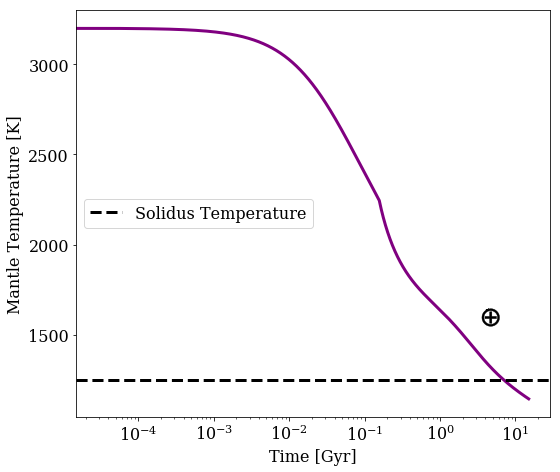

In [155]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_CA*T_ref, color='purple', linewidth=3)
plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')
plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='center left', fontsize=16)
#plt.savefig('Recoded_CA_Model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_Model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_Model_MantleTemp_extremeloss.pdf', bbox_inches='tight')

In [157]:
# Mark degassing, regassing limit on figure, if reached.
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr] MY CALCULATION

max_dg_idx = np.where(degas_array_CA == np.max(degas_array_CA))
max_rg_idx = np.where(regas_array_CA == np.max(regas_array_CA))

print(t_array_CA[max_dg_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, degas_array_CA[max_dg_idx]*dr_conv/1.0e11)
print(t_array_CA[max_rg_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, regas_array_CA[max_rg_idx]*dr_conv/1.0e11)

# Mark where surface becomes Dune, then desiccated, then where it begins recovering.
tolerance = 1.29e16/(2.3e-4*1.3*M_E)

dune_first_idx = -1
for ldx in range(0,len(s_array_CA)):
    if s_array_CA[ldx] <= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
        dune_first_idx = ldx
        break

desiccated_idx = -1
if dune_first_idx >= 0:
    for idx in range(dune_first_idx+1,len(s_array_CA)):
        if s_array_CA[idx] <= tolerance:
            desiccated_idx = idx
            break 

recover_idx = -1
if desiccated_idx >= 0:
    for jdx in range(desiccated_idx+1,len(s_array_CA)):
        if s_array_CA[jdx] >= tolerance:
            recover_idx = jdx
            print(s_array_CA[jdx]*(2.3e-4*1.3*M_E))
            break
            
dune_idx = -1
if recover_idx >= 0:
    for kdx in range(recover_idx+1,len(s_array_CA)):
        if s_array_CA[kdx] >= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
            dune_idx = kdx
            break
            
print(desiccated_idx, recover_idx, dune_idx)

[0.00655099] [5.42157619]
[0.] [6.46127584]
1.5000170885758088e+16
1781 5435 19082


In [87]:
print(t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9 - t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9)

0.4966108030021165


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


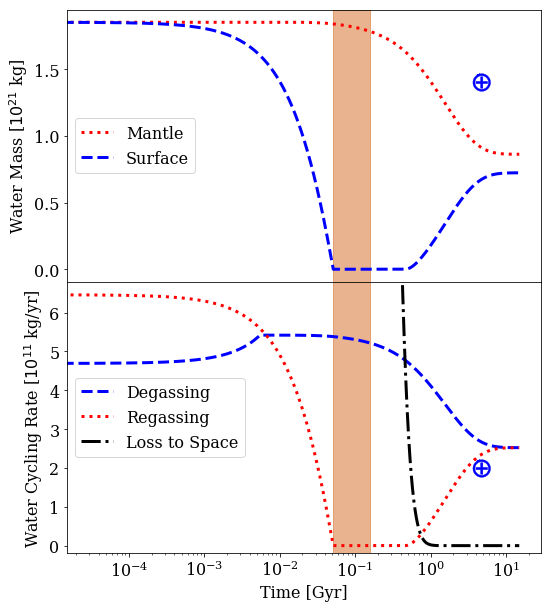

In [65]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

ax1 = plt.subplot(2,1,1)
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')
#plt.axvline(x=t_array_CA[max_dg_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Max Degassing')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
#plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

#FILL-IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#plt.plot(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
#plt.plot(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_CA*2.87, ((s_array_CA*kg_conv/1000./1.0e18)-M_hydr_CA/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_CA*2.87, M_hydr_CA/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
#plt.semilogx([0., 287], [1.32*kg_conv/1000./1.0e18, 1.32*kg_conv/1000./1.0e18], color='k', linestyle='--', label='Earth Mantle Water')
#plt.semilogx([0., 287], [1.39, 1.39], color='k', linestyle=':', label='Earth Surface Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='center left', fontsize=16)
#plt.legend(bbox_to_anchor=(-0.05, 1.0), ncol=2, fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr] MY CALCULATION
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax2 = plt.subplot(2,1,2)
#could also multiply by dr_conv*exa_gyr_conv to get 10^21 kg/Gyr
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (degas_array_CA*dr_conv/1.0e11), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (regas_array_CA*dr_conv/1.0e11), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (loss_array_CA*dr_conv/1.0e11), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_CA[max_dg_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Max Degassing')
#plt.axvline(x=t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')
#plt.axvline(x=t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

#FILL-IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
plt.plot(4.5, 18, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
plt.errorbar(4.5, 18, yerr=11, ecolor='r', capsize=5) #regassing uncertainty
plt.plot(4.5, 2, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#plt.plot(4.5, 0.002, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.ylabel(r'Water Cycling Rate [$10^{11}$ kg/yr]', fontsize=16)
plt.ylim([-0.2,6.8])
plt.legend(loc='center left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.0, 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_CA_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_exploss_lossrate.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_extremeloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_extremeloss_lossrate.pdf', bbox_inches='tight')
#plt.savefig('Comps_Presentation_Fig.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


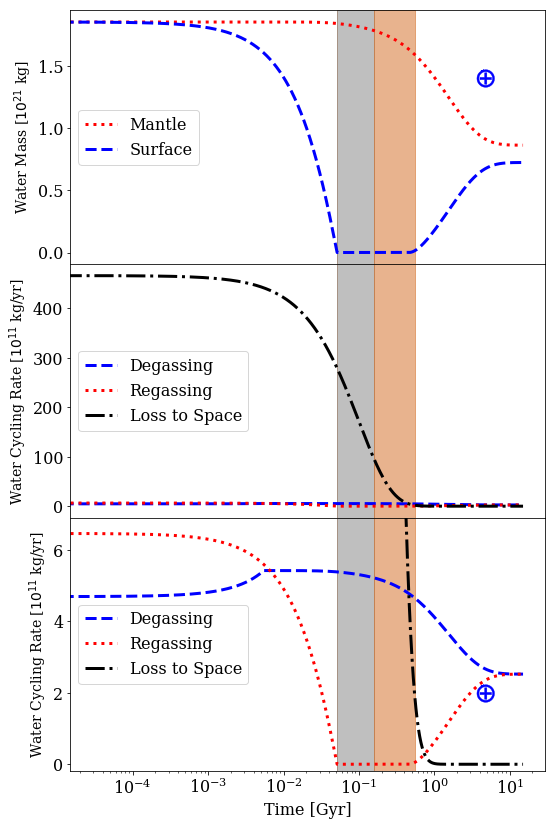

In [69]:
## %matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,14))
plt.tight_layout()
ax = [fig.add_subplot(3,1,i+1) for i in range(3)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

ax1 = plt.subplot(3,1,1)
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')
#plt.axvline(x=t_array_CA[max_dg_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Max Degassing')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
#plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE PLANET FIRST BECOMES DUNE
plt.axvspan(t_array_CA[dune_first_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
#FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[dune_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')


#plt.plot(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
#plt.plot(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_CA*2.87, ((s_array_CA*kg_conv/1000./1.0e18)-M_hydr_CA/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_CA*2.87, M_hydr_CA/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
#plt.semilogx([0., 287], [1.32*kg_conv/1000./1.0e18, 1.32*kg_conv/1000./1.0e18], color='k', linestyle='--', label='Earth Mantle Water')
#plt.semilogx([0., 287], [1.39, 1.39], color='k', linestyle=':', label='Earth Surface Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=14)
plt.legend(loc='center left', fontsize=16)
#plt.legend(bbox_to_anchor=(-0.05, 1.0), ncol=2, fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr] MY CALCULATION
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax2 = plt.subplot(3,1,2)
#could also multiply by dr_conv*exa_gyr_conv to get 10^21 kg/Gyr
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (degas_array_CA*dr_conv/1.0e11), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (regas_array_CA*dr_conv/1.0e11), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (loss_array_CA*dr_conv/1.0e11), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_CA[max_dg_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Max Degassing')
#plt.axvline(x=t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')
#plt.axvline(x=t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# FILL IN REGION WHERE PLANET FIRST BECOMES DUNE
plt.axvspan(t_array_CA[dune_first_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
#FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[dune_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.ylabel(r'Water Cycling Rate [$10^{11}$ kg/yr]', fontsize=14)
#plt.ylim([0,0.2])
plt.legend(loc='center left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.0, 1.0), ncol=2, fontsize=16)

ax3 = plt.subplot(3,1,3)
#could also multiply by dr_conv*exa_gyr_conv to get 10^21 kg/Gyr
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (degas_array_CA*dr_conv/1.0e11), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (regas_array_CA*dr_conv/1.0e11), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (loss_array_CA*dr_conv/1.0e11), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_CA[max_dg_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Max Degassing')
#plt.axvline(x=t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')
#plt.axvline(x=t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 18, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 18, yerr=11, ecolor='r', capsize=5) #regassing uncertainty
plt.plot(4.5, 2, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN REGION WHERE PLANET FIRST BECOMES DUNE
plt.axvspan(t_array_CA[dune_first_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
#FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[dune_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.ylabel(r'Water Cycling Rate [$10^{11}$ kg/yr]', fontsize=14)
#plt.ylim([4.6, 6.54]) #exponential loss
plt.ylim([-0.2,6.9]) #extreme loss
plt.legend(loc='center left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.0, 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_CA_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_exploss_lossrate.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_extremeloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_extremeloss_lossrate_paper.pdf', bbox_inches='tight')

<Figure size 1224x540 with 0 Axes>

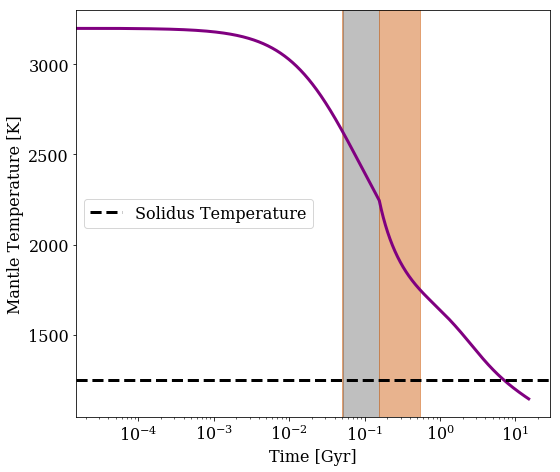

In [166]:
# Mantle temperature, with shaded regions showing Dune/desiccated.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_CA*T_ref, color='purple', linewidth=3)
plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')

# FILL IN REGION WHERE PLANET FIRST BECOMES DUNE
plt.axvspan(t_array_CA[dune_first_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
#FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[dune_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='center left', fontsize=16)
#plt.savefig('Recoded_CA_Model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_Model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_Model_MantleTemp_extremeloss_shaded.pdf', bbox_inches='tight')

<Figure size 1224x540 with 0 Axes>

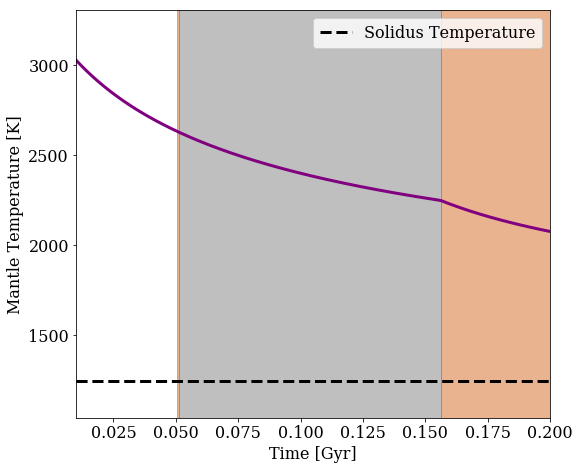

In [171]:
# Mantle temperature, with shaded regions showing Dune/desiccated. -- Linear x-axis.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.plot(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_CA*T_ref, color='purple', linewidth=3)
plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')

# FILL IN REGION WHERE PLANET FIRST BECOMES DUNE
plt.axvspan(t_array_CA[dune_first_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
#FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[dune_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlim([0.01,0.2])
#plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_CA_Model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_Model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_Model_MantleTemp_extremeloss_shaded_zoom.pdf', bbox_inches='tight')

In [169]:
#print(s_array_CA[0])
print(regas_array_CA[-1] - degas_array_CA[-1])
#print(regas_array_CA[0]*dr_conv*year, 'kg/year')


-7.065704122821703e-05


In [ ]:
plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlim([1e-2,1.])

# SS Model, using scipy.integrate

In [13]:
# Define functions to be used within this model (and hybrid), based on mass.

def D(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return x_h*rho_c*chi_r*(h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*\
        (kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*f_w))**beta

def Sigma(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return M*omega_0*f_btwid*((h(M)**(1.-6.*beta))*(kappa**(2.*beta-1.))/\
        (10.76*L_MOR(M)))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*f_w))**(2.*beta)

def tau_SS(M, params1, params2, params3, params4):
    
    return D(M, params1, params2, params3, params4)/Sigma(M, params1, params2, params3, params4)

def Pitwid(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/D(M, params1, params2, params3, params4)

def D_2(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1., params1, params2, params3))))**beta

def D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(1.+beta))
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_min**beta)*((temp_twid-T_stwid)**(1.+beta))

def Pitwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

#tau_heat = Q_0/(rho_m*c_p*T_ref) #NOTE: TAD USES F_0 IN PLACE OF Q_0 IN THIS TIMESCALE

In [14]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

# XXXX ARE THE MANTLE TEMPERATURE FUNCTIONS THE SAME NOW? IF SO, ONLY DEFINE ONE XXXX
def f_delta_temp_SS(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid

    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif s_twid <= 0.:
                dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif s_twid <= 0.:
                dx_twid = 0. - 0.
                
        # Can't store more water in mantle than its capacity.  XXX CAN MAKE THIS MORE ROBUST LATER XXX        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            dx_twid = (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            dx_twid = (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid <= 0.:
            dx_twid = 0. - 0.
            
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            dx_twid = 0. - 0.
            
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0.
                    
def f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4): # NEED TO ADD LOSS TO THIS 
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # This can either turn off loss, or increase the loss rate.
    #loss_factor = 0.
    loss_factor = 10.*loss_factor # EXTREME loss
        
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. \
                    - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = 0. - (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = 0. - (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0.:
                ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid <= 0.:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
        
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            ds_twid = 0. - 0. - 0.
        
        # Surface water capacity check
        if s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_SS(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    # Dividing by tau(M) helps put these on the same timescale.
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_SS(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]

In [15]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.: #water on surface
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0.:
            return 0.
                
    elif s_twid <= 0.: #no water on surface; no regassing
        return 0.
    
def f_degas_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0.: #water in mantle
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            return 0.
                                                                                        
    elif x_twid <= 0.: #no water in mantle; no degassing
        return 0.
    
def f_loss_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # This can either turn off loss, or increase the loss rate.
    #loss_factor = 0.
    loss_factor = 10.*loss_factor # EXTREME loss
    
# OPTION 2: CAN ADD OPTION 1 OR 3 BASED ON CA RESULTS LATER XXXXXX
#    if s_twid > 0.: #normal loss
#        return (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
#    elif s_twid <= 0.: #no loss
#        return 0.

# OPTION 3: DON'T WORRY ABOUT WATER, JUST SHOW RATE
    return (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)

In [16]:
def omega_hydr_twid_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)
    

In [179]:
# Set initial conditions.
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
#z0 = [2., 1.4e21/M_E/(omega_0*f_btwid), 50.*1.4e21/M_E/(omega_0*f_btwid)]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_SS).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M, params1, params2, params3, params4)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 5.22 #cycling rate over tau instead of tau_SS? If not -->#6.76 #~15 Gyr #100.
dt = 1.e-5
t_array_SS = np.zeros(int(t1/dt)+1)
T_array_SS = np.zeros(int(t1/dt)+1)
x_array_SS = np.zeros(int(t1/dt)+1)
s_array_SS = np.zeros(int(t1/dt)+1)
regas_array_SS = np.zeros(int(t1/dt)+1)
degas_array_SS = np.zeros(int(t1/dt)+1)
loss_array_SS = np.zeros(int(t1/dt)+1)
omega_hydr_array_SS = np.zeros(int(t1/dt)+1)
eta_array_SS = np.zeros(int(t1/dt)+1)

# Initial values in the arrays.
t_array_SS[0] = t0
T_array_SS[0] = z0[0]
x_array_SS[0] = z0[1]
s_array_SS[0] = z0[2]
regas_array_SS[0] = f_regas_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
degas_array_SS[0] = f_degas_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
loss_array_SS[0] = f_loss_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
omega_hydr_array_SS[0] = omega_hydr_twid_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
eta_array_SS[0] = eta(z0[0], z0[1], params1, params2, params3)

# Integrate the above function.
idx = 1
#while r.successful() and r.t < t1:

start_time = time.time()

for idx in range(1,len(t_array_SS)):
    
    if r.successful() == True:
        r.integrate(r.t+dt)
        t_array_SS[idx] = r.t
        T_array_SS[idx] = r.y[0]
        x_array_SS[idx] = r.y[1]
        s_array_SS[idx] = r.y[2]
        regas_array_SS[idx] = f_regas_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        degas_array_SS[idx] = f_degas_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        loss_array_SS[idx] = f_loss_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        omega_hydr_array_SS[idx] = omega_hydr_twid_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        eta_array_SS[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
        
    elif r.successful() == False:
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
        t_array_SS[idx] = t_array_SS[idx-1] + dt
        
        T_array_SS[idx] = T_array_SS[idx-1] + \
            f_delta_temp_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], M, params1, params2, params3, params4)*dt
        x_array_SS[idx] = x_array_SS[idx-1] + \
            f_delta_x_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], s_array_SS[idx-1], M, params1, params2, params3, params4)*dt
        s_array_SS[idx] = s_array_SS[idx-1] + \
            f_delta_s_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], s_array_SS[idx-1], M, params1, params2, params3, params4)*dt
        
        regas_array_SS[idx] = f_regas_SS(t_array_SS[idx], T_array_SS[idx], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
        degas_array_SS[idx] = f_degas_SS(t_array_SS[idx], T_array_SS[idx], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
        loss_array_SS[idx] = f_loss_SS(t_array_SS[idx], T_array_SS[idx], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
        omega_hydr_array_SS[idx] = omega_hydr_twid_SS(t_array_SS[idx], T_array_SS[idx], x_array_SS[idx], s_array_SS[idx-1], M, params1, params2, params3, params4)
        eta_array_SS[idx] = eta(T_array_SS[idx], x_array_SS[idx], params1, params2, params3)
    
        # Leave the loop if both reservoirs have zero water.
        if x_array_SS[idx] <= 0. and s_array_SS[idx] <= 0.:
            break
    
    #idx = idx + 1
    
end_time = time.time()
print(end_time-start_time, ' s')
    
# Mass of water in hydrated layer
M_hydr_SS = omega_hydr_array_SS*2.3e-4*1.3*M_E #[kg]

/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))


384.1765968799591  s


In [ ]:
#print(6.76/tau_SS(M_E, params1,params2,params3,params4)/year)
#print(15e9*tau_SS(M_E, params1,params2,params3,params4)*year)

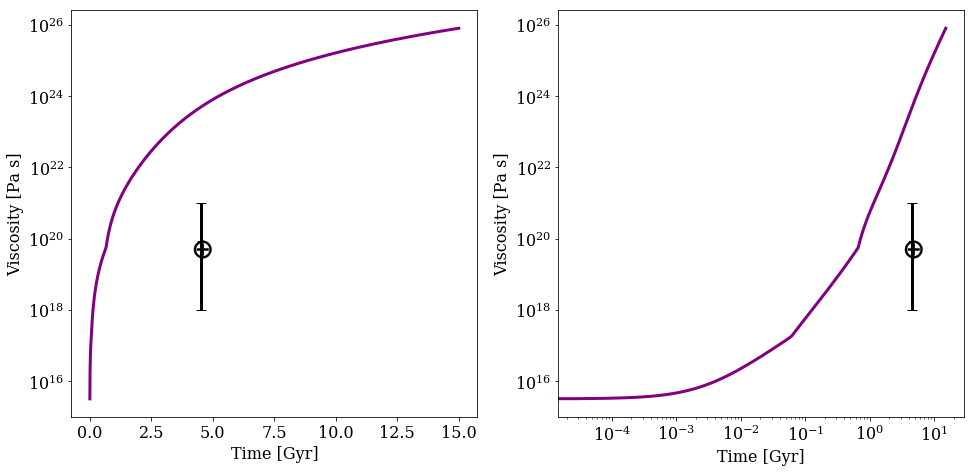

In [148]:
# Viscosity

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(16,7.5))

plt.subplot(1,2,1)
plt.semilogy(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, eta_array_SS, color='purple', linewidth=3)

# Viscosity of Earth's mantle today
plt.semilogy(4.5, 5e19, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
asym_yerr = [[4.9e19],[9.5e20]]
plt.errorbar(4.5, 5e19, yerr=asym_yerr, ecolor='k', capsize=5, linewidth=3)

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Viscosity [Pa s]', fontsize=16)

plt.subplot(1,2,2)
plt.loglog(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, eta_array_SS, color='purple', linewidth=3)

# Viscosity of Earth's mantle today
plt.semilogy(4.5, 5e19, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
asym_yerr = [[4.9e19],[9.5e20]]
plt.errorbar(4.5, 5e19, yerr=asym_yerr, ecolor='k', capsize=5, linewidth=3)

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Viscosity [Pa s]', fontsize=16)
plt.savefig('Recoded_SS_cycling_extremeloss_viscosity.pdf')

In [149]:
# Find where degassing shuts off, i.e., when mantle temperature drops below solidus.
for idx in range(0,len(T_array_SS)):
    if T_array_SS[idx]*T_ref <= T_sol_dry:
        print(t_array_SS[idx]/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_SS[idx]*T_ref)
        dg_off_idx = idx
        break

10.743737184044322 1248.1499111406213


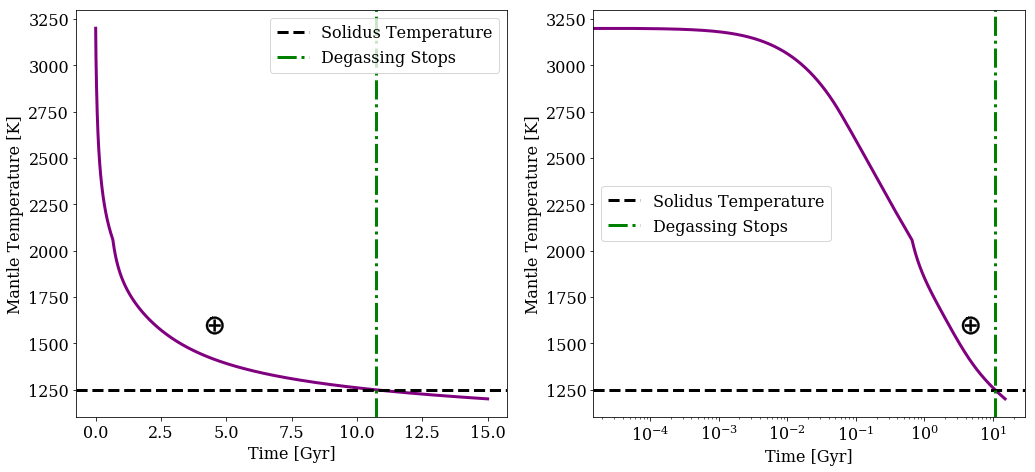

In [150]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))

ax = plt.subplot(1,2,1)
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_SS*T_ref, color='purple', linewidth=3)
plt.plot(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_SS*T_ref, color='purple', linewidth=3)
#plt.semilogx(tmp_time_array_SS*2.22, tmp_temp_array_SS*1600., color='purple')
plt.axhline(y=T_soltwid*T_ref, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')
plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
#plt.legend(loc='center left', fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_SS*T_ref, color='purple', linewidth=3)
#plt.plot(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_SS*T_ref, color='purple', linewidth=3)
#plt.semilogx(tmp_time_array_SS*2.22, tmp_temp_array_SS*1600., color='purple')
plt.axhline(y=T_soltwid*T_ref, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')
plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='center left', fontsize=16)
#plt.legend(loc='upper right', fontsize=16)

#plt.savefig('Recoded_SS_model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_MantleTemp_linearx_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_MantleTemp_extremeloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_MantleTemp_linearx_extremeloss.pdf', bbox_inches='tight')

<Figure size 1224x540 with 0 Axes>

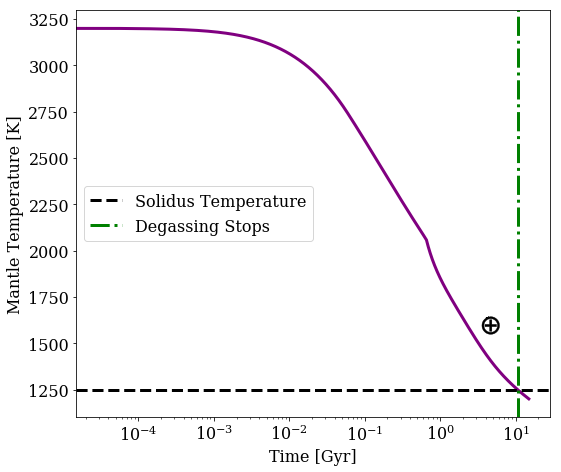

In [151]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_SS*T_ref, color='purple', linewidth=3)
plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')
plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='center left', fontsize=16)
#plt.savefig('Recoded_SS_Model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_Model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_Model_MantleTemp_extremeloss.pdf', bbox_inches='tight')

In [172]:
# Mark where surface becomes desiccated, then where it begins recovering.
tolerance = 1.29e16/(2.3e-4*1.3*M_E)

dune_first_idx_SS = -1
for ldx in range(0,len(s_array_SS)):
    if s_array_SS[ldx] <= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
        dune_first_idx_SS = ldx
        break

desiccated_idx_SS = -1
if dune_first_idx_SS >= 0:
    for idx in range(dune_first_idx_SS+1,len(s_array_SS)):
        if s_array_SS[idx] <= tolerance:
            desiccated_idx_SS = idx
            break
        
recover_idx_SS = -1
if desiccated_idx_SS >= 0:
    for jdx in range(desiccated_idx_SS+1,len(s_array_SS)):
        if s_array_SS[jdx] >= tolerance:
            recover_idx_SS = jdx
            break
                     
dune_idx_SS = -1
if recover_idx_SS >= 0:
    for kdx in range(recover_idx_SS+1,len(s_array_SS)):
        if s_array_SS[kdx] >= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
            dune_idx_SS = kdx
            break
            
print(desiccated_idx_SS, recover_idx_SS)

2267 48165


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


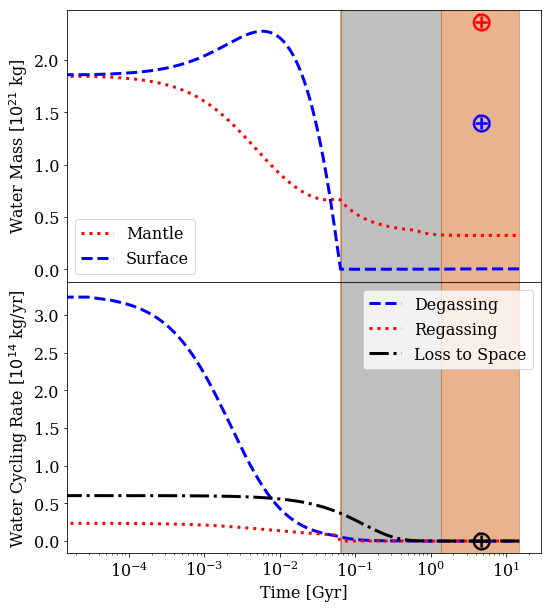

In [173]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_SS = (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper

ax = plt.subplot(2,1,1)
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)
#plt.axvline(x=t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')


# FILL IN WHERE IT FIRST BECOMES A DUNE PLANET
plt.axvspan(t_array_CA[dune_first_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[dune_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, ((s_array_SS*kg_conv/1000./1.0e18)-M_hydr_SS/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, M_hydr_SS/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2)
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*degas_array_SS*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*regas_array_SS*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*loss_array_SS*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Loss to Space')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 0.018, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 0.018, yerr=0.011, ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 0.002, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
plt.plot(4.5, 0.002, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN WHERE IT FIRST BECOMES A DUNE PLANET
plt.axvspan(t_array_CA[dune_first_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_CA[dune_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')
#plt.axvline(x=t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.')#, label='Ocean Rejuvenation')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
#plt.ylim([-1, 5.])
plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0., 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_SS_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_cycling_extremeloss.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


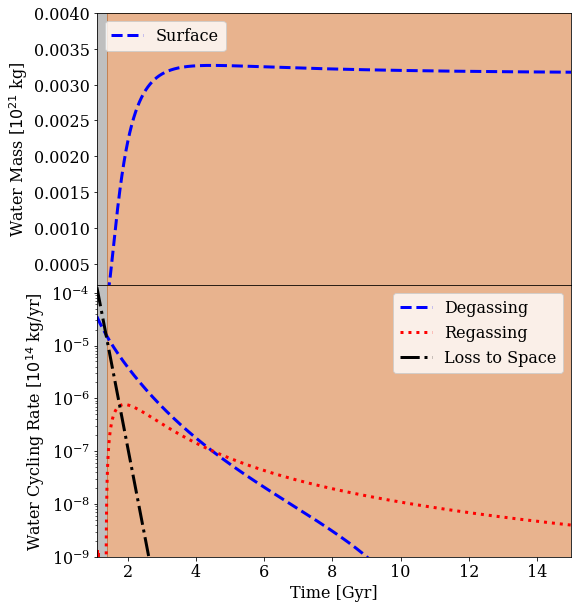

In [185]:
# Play around with plotting log/linear on x/y axes.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_SS = (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper

ax = plt.subplot(2,1,1)
#plt.plot(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.plot(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)
#plt.axvline(x=t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
#plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN WHERE IT FIRST BECOMES A DUNE PLANET
plt.axvspan(t_array_CA[dune_first_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[dune_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, ((s_array_SS*kg_conv/1000./1.0e18)-M_hydr_SS/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, M_hydr_SS/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([t_array_CA[recover_idx_SS-10000]/tau(M_E,params1,params2,params3)/year/1.0e9, 15.])
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylim([2.0e-4,4.0e-3])
plt.legend(loc='upper left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2)
plt.semilogy(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*degas_array_SS*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogy(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*regas_array_SS*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogy(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*loss_array_SS*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Loss to Space')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 0.018, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 0.018, yerr=0.011, ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 0.002, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
plt.plot(4.5, 0.002, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN WHERE IT FIRST BECOMES A DUNE PLANET
plt.axvspan(t_array_CA[dune_first_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[dune_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')
#plt.axvline(x=t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.')#, label='Ocean Rejuvenation')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([t_array_CA[recover_idx_SS-10000]/tau(M_E,params1,params2,params3)/year/1.0e9, 15.])
plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.ylim([1.0e-9, 1.4e-4])
plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0., 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_SS_model_cycling_extremeloss_Dunezoom.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


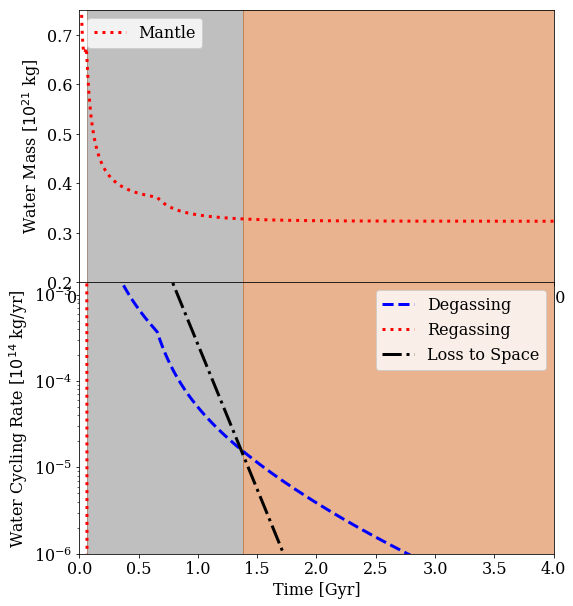

In [197]:
# Play around with plotting log/linear on x/y axes.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_SS = (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper

ax = plt.subplot(2,1,1)
plt.plot(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
#plt.plot(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)
#plt.axvline(x=t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
#plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN WHERE IT FIRST BECOMES A DUNE PLANET
plt.axvspan(t_array_CA[dune_first_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[dune_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, ((s_array_SS*kg_conv/1000./1.0e18)-M_hydr_SS/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, M_hydr_SS/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.001, 4.])
plt.ylim([0.2,0.75])
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
#plt.ylim([2.0e-4,4.0e-3])
plt.legend(loc='upper left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2)
plt.semilogy(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*degas_array_SS*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogy(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*regas_array_SS*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogy(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*loss_array_SS*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Loss to Space')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 0.018, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 0.018, yerr=0.011, ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 0.002, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
plt.plot(4.5, 0.002, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN WHERE IT FIRST BECOMES A DUNE PLANET
plt.axvspan(t_array_CA[dune_first_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[dune_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')
#plt.axvline(x=t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.')#, label='Ocean Rejuvenation')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.001, 4.])
plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.ylim([1.0e-6, 1.4e-3])
plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0., 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_SS_model_cycling_extremeloss_mantlezoom.pdf', bbox_inches='tight')

<Figure size 1224x540 with 0 Axes>

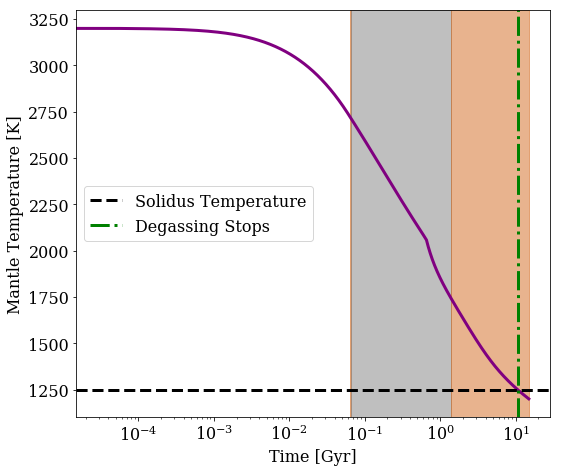

In [175]:
# Mantle temperature evolution, with shaded desiccated/Dune regions.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_SS*T_ref, color='purple', linewidth=3)
plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')
plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)

# FILL IN WHERE IT FIRST BECOMES A DUNE PLANET
plt.axvspan(t_array_CA[dune_first_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[dune_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='center left', fontsize=16)
#plt.savefig('Recoded_SS_Model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_Model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_Model_MantleTemp_extremeloss_shaded.pdf', bbox_inches='tight')

<Figure size 1224x540 with 0 Axes>

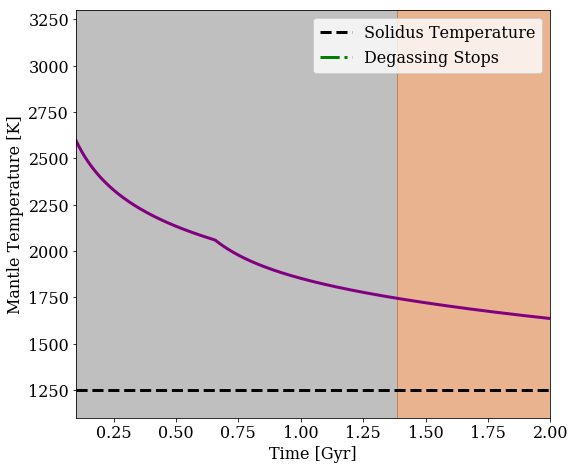

In [183]:
# Mantle temperature evolution, with shaded desiccated/Dune regions. ZOOMED IN ON SHADED REGIONS.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.plot(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_SS*T_ref, color='purple', linewidth=3)
plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')
plt.axvline(x=t_array_SS[dg_off_idx]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)

# FILL IN WHERE IT FIRST BECOMES A DUNE PLANET
plt.axvspan(t_array_CA[dune_first_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_CA[desiccated_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_CA[recover_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_SS[dune_idx_SS]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlim([1.0e-1,2.])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_SS_Model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_Model_MantleTemp_exploss.pdf', bbox_inches='tight')
plt.savefig('Recoded_SS_Model_MantleTemp_extremeloss_shaded_zoom.pdf', bbox_inches='tight')

# Hybrid Model, using scipy.integrate --> GOOD!
## This is the quickest way to run through this cycling, so just code it this way from the beginning.

In [17]:
# Many functions have already been defined for the SS model -- only define new things here.

def Etwid(M,params1,params2,params3,params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/D(M,params1,params2,params3,params4)

def Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

In [31]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.
def f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
            
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif s_twid <= 0.:
                 dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
                    
        else: #mantle temperature below solidus, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            elif s_twid <= 0.:
                 dx_twid = 0. - 0.
                
        #Mantle water capacity check        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid <= 0.:
             dx_twid = 0. - 0.
                
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        #Degassing check from CA2014 (only one option for degas though) + solidus temperature check
        
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        else: #mantle temperature below solidus, degassing shuts off
            dx_twid = 0. - 0.
        
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # This can either turn loss off, or change the loss rate.
    loss_factor = 0. #no loss
    #leave loss_factor as is -- exponential loss
    #loss_factor = 10.*loss_factor # EXTREME loss
        
    #Try same loss factors as grid search -- nominal 10 TO/Gyr first (with t_loss = 10^8 yr).
    #Fiducial
    #loss_factor = 10*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*tau(M,params1,params2,params3)/tau_SS(M,params1,params2,params3,params4)
    t_loss = 1.0e8
    
    # 10x higher loss, 0.1x loss timescale.
    #loss_factor = 100*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*tau(M,params1,params2,params3)/tau_SS(M,params1,params2,params3,params4) #EXTREME loss?
    #t_loss = 1.0e7
        
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
            
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = dg_hyb - \
                    (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = dg_hyb - \
                    (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
                
        else: #mantle temperature below solidus, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = 0. - \
                    (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = 0. - \
                    (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0.:
                ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid <= 0.:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
        else: #mantle temperature below solidus, degassing shuts off
            ds_twid = 0. - 0. - 0.
        
        # Surface water capacity check
        if s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_hyb(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]
    

In [32]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.:
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid <= 0.:
             return 0.
            
    elif s_twid <= 0.:
        return 0.
    
def f_degas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # Solidus temperature check
    if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling

        # Degassing check from CA2014
        if x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE): #normal degassing
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        elif x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) >= (1./f_degasE):
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        elif x_twid > 0. and s_twid <= 0.:
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        else: #if x_twid <= 0. OR s_twid <=0 ; no degassing --> depends on seafloor pressure, no water = no pressure
            return 0.
        
    else: #mantle temperature below solidus, degassing shuts off
        return 0.
    
def f_loss_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # This can either turn loss off, or change the loss rate.
    loss_factor = 0. #no loss
    #leave loss_factor as is -- exponential loss
    #loss_factor = 10.*loss_factor #EXTREME loss
    
    #Try same loss factors as grid search -- nominal 10 TO/Gyr first (with t_loss = 10^8 yr).
    #Fiducial
    #loss_factor = 10*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*tau(M,params1,params2,params3)/tau_SS(M,params1,params2,params3,params4)
    t_loss = 1.0e8
    
    # 10x higher loss, 0.1x loss timescale.
    #loss_factor = 100*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*tau(M,params1,params2,params3)/tau_SS(M,params1,params2,params3,params4) #EXTREME loss?
    #t_loss = 1.0e7

    #if s_twid > 0.: #normal loss
    return (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
    #elif s_twid <= 0.: #no loss
    #    return 0.

In [33]:
def omega_hydr_twid_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)  

In [34]:
# Mantle overturn timescale (by either advection or convection)

def tau_over_adv(T_twid, x_twid, M, params1, params2, params3):
    
    return (eta(T_twid, x_twid, params1, params2, params3) / (alpha*rho_m*((T_twid*T_ref)-T_s)*\
            g(M)*h(M))) * (Ra(T_twid, x_twid, M, params1, params2, params3)/Ra_c)**(1./3.)

def tau_over_conv(T_twid, M, params1, params2, params3):
    
    nu = 2.5e17 #[m^2/s]
    
    return (1./(5.38*kappa)) * (nu*kappa*Ra_c/(alpha*g(M)*((T_twid*T_ref)-T_s)))**(2./3.)

In [35]:
# Set initial conditions.
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
#z0 = [2., 1.4e21/M_E/(omega_0*f_btwid), 50.*1.4e21/M_E/(omega_0*f_btwid)]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_hyb).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 5.22 #cycling rate over tau instead of tau_SS? If not -->#6.76 #~15 Gyr #100.
dt = 1.e-5
t_array_hyb = np.zeros(int(t1/dt)+1)
T_array_hyb = np.zeros(int(t1/dt)+1)
x_array_hyb = np.zeros(int(t1/dt)+1)
s_array_hyb = np.zeros(int(t1/dt)+1)
regas_array_hyb = np.zeros(int(t1/dt)+1)
degas_array_hyb = np.zeros(int(t1/dt)+1)
loss_array_hyb = np.zeros(int(t1/dt)+1)
omega_hydr_array_hyb = np.zeros(int(t1/dt)+1)
#eta_array_CA = np.zeros(int(t1/dt))

# Initial values in the arrays.
t_array_hyb[0] = t0
T_array_hyb[0] = z0[0]
x_array_hyb[0] = z0[1]
s_array_hyb[0] = z0[2]
regas_array_hyb[0] = f_regas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
degas_array_hyb[0] = f_degas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
loss_array_hyb[0] = f_loss_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
omega_hydr_array_hyb[0] = omega_hydr_twid_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)

# Integrate the above function.
idx = 1
#while r.successful() and r.t < t1:

start_time = time.time()

for idx in range(1,len(t_array_hyb)):
    
    if r.successful() == True:
        r.integrate(r.t+dt)
        t_array_hyb[idx] = r.t
        T_array_hyb[idx] = r.y[0]
        x_array_hyb[idx] = r.y[1]
        s_array_hyb[idx] = r.y[2]
        regas_array_hyb[idx] = f_regas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        degas_array_hyb[idx] = f_degas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        loss_array_hyb[idx] = f_loss_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
    
    elif r.successful() == False:
        
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
        t_array_hyb[idx] = t_array_hyb[idx-1] + dt
        
        T_array_hyb[idx] = T_array_hyb[idx-1] + \
            f_delta_temp_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        x_array_hyb[idx] = x_array_hyb[idx-1] + \
            f_delta_x_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        s_array_hyb[idx] = s_array_hyb[idx-1] + \
            f_delta_s_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        
        regas_array_hyb[idx] = f_regas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        degas_array_hyb[idx] = f_degas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        loss_array_hyb[idx] = f_loss_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        
        # Leave the loop if both reservoirs have zero water.
        if x_array_hyb[idx] <= 0. and s_array_hyb[idx] <= 0.:
            break
    
    #idx = idx + 1
    
end_time = time.time()
print(end_time-start_time, ' s')
    
# Mass of water in hydrated layer
M_hydr_hyb = omega_hydr_array_hyb*2.3e-4*1.3*M_E #[kg]

188.1547360420227  s


In [39]:
print(loss_factor)

7.5


In [23]:
# WRONG! USE THE WET SOLIDUS! --- Find where degassing shuts off, i.e., when mantle temperature drops below solidus.
#for idx in range(0,len(T_array_hyb)):
#    if T_array_hyb[idx]*T_ref <= T_sol_dry:
#        print(t_array_hyb[idx]/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_hyb[idx]*T_ref)
#        dg_off_idx_hyb = idx
#        break
        
#print(T_array_hyb[-1]*T_ref)

12.55545545505577 1248.1498916885002
1223.185988626541


No handles with labels found to put in legend.


<Figure size 1224x540 with 0 Axes>

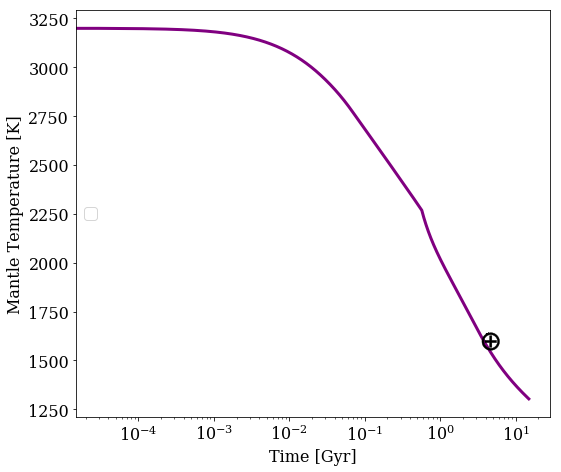

In [37]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_hyb*T_ref, linewidth=3, color='purple')
#plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3,label='Solidus Temperature')
plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='center left', fontsize=16)

#plt.savefig('Recoded_hyb_model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_MantleTemp_extremeloss.pdf', bbox_inches='tight')

In [23]:
# Mark where surface becomes desiccated, then where it begins recovering.
tolerance = 1.29e16/(2.3e-4*1.3*M_E)

dune_first_idx_hyb = -1
for ldx in range(0,len(s_array_hyb)):
    if s_array_hyb[ldx] <= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
        dune_first_idx_hyb = ldx
        break

desiccated_idx_hyb = -1
if dune_first_idx_hyb >= 0:
    for idx in range(dune_first_idx_hyb+1,len(s_array_hyb)):
        if s_array_hyb[idx] <= tolerance:
            desiccated_idx_hyb = idx
            break
        
recover_idx_hyb = -1
if desiccated_idx_hyb >= 0:
    for jdx in range(desiccated_idx_hyb+1,len(s_array_hyb)):
        if s_array_hyb[jdx] >= tolerance:
            recover_idx_hyb = jdx
            break
                     
dune_idx_hyb = -1
if recover_idx_hyb >= 0:
    for kdx in range(recover_idx_hyb+1,len(s_array_hyb)):
        if s_array_hyb[kdx] >= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
            dune_idx_hyb = kdx
            break
            
print(desiccated_idx_hyb, recover_idx_hyb)

938 54573


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


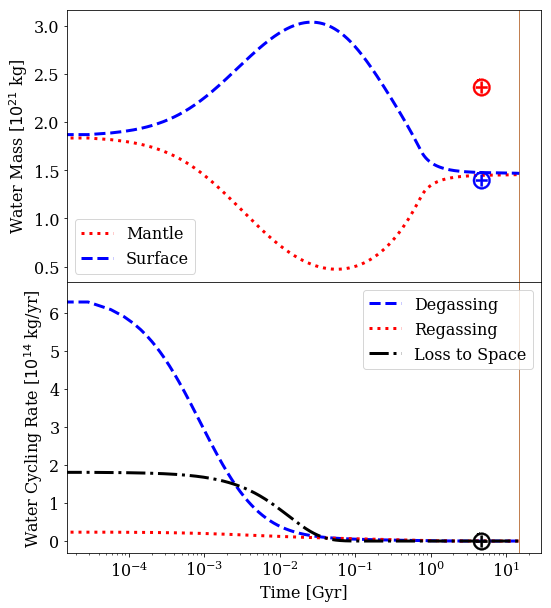

In [225]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(2,1,1)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_array_hyb*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_array_hyb*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_array_hyb*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 0.018, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 0.018, yerr=0.011, ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 0.002, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
plt.plot(4.5, 0.002, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0.05, 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_hyb_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss_2panel.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_2panel.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_xlimit.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


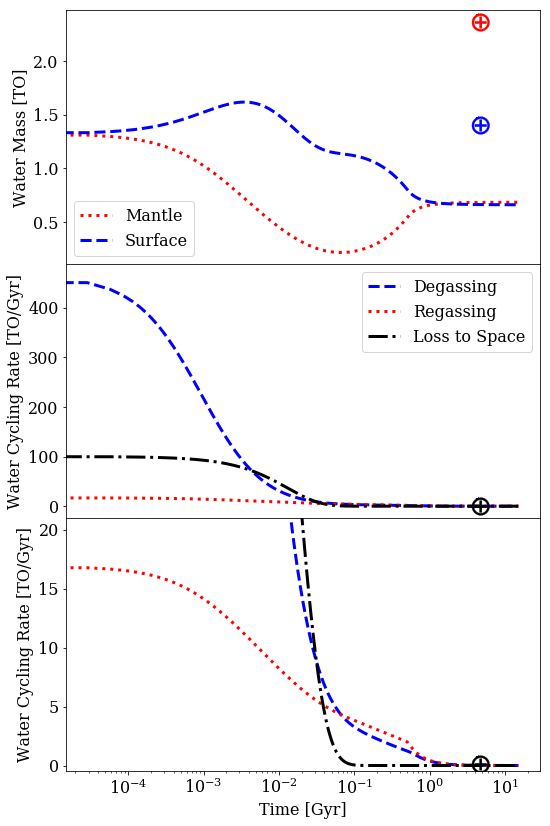

In [279]:
#Same as above, but with a third panel zoomed in on the lower rates to better observe their behaviour.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,14))
plt.tight_layout()
ax = [fig.add_subplot(3,1,i+1) for i in range(3)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(3,1,1)
# WATER INVENTORIES IN KG
#plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
#plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
# WATER INVENTORIES IN TO
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1.4e21), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1.4e21), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
#plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel('Water Mass [TO]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(3,1,2)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_array_hyb*dr_conv/1.4e21*1.0e9), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_array_hyb*dr_conv/1.4e21*1.0e9), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_array_hyb*dr_conv/1.4e21*1.0e9), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 1.8e12/1.4e21*1.0e9, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 1.8e12/1.4e21*1.0e9, yerr=1.1e12/(1.4e21*1.0e9), ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
#plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.ylabel('Water Cycling Rate [TO/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0.05, 1.0), ncol=2, fontsize=16)

ax = plt.subplot(3,1,3)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_array_hyb*dr_conv/1.4e21*1.0e9), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_array_hyb*dr_conv/1.4e21*1.0e9), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_array_hyb*dr_conv/1.4e21*1.0e9), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 1.8e12/1.4e21*1.0e9, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 1.8e12/1.4e21*1.0e9, yerr=1.1e12/(1.4e21*1.0e9), ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
plt.ylim([-0.5, 21.])
#plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.ylabel('Water Cycling Rate [TO/Gyr]', fontsize=16)
#plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0.05, 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_hyb_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss_3panel.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss_3panel_10lossrate_01losstime.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_3panel.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_xlimit.pdf', bbox_inches='tight')

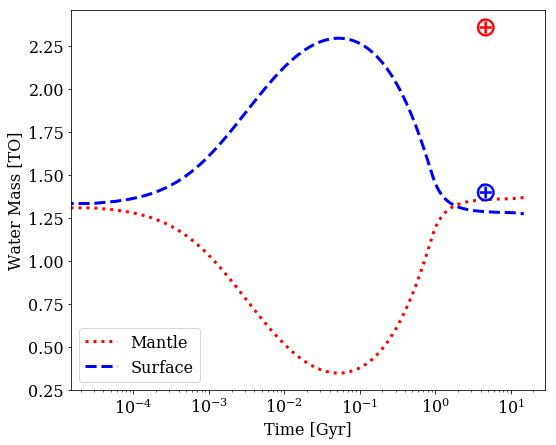

In [36]:
# ONE PANEL -- just show evolution of reservoirs over time
# Good for talks!

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7))
plt.tight_layout()
#ax = [fig.add_subplot(3,1,i+1) for i in range(3)]
#fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

#ax = plt.subplot(3,1,1)
# WATER INVENTORIES IN KG
#plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
#plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
# WATER INVENTORIES IN TO
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1.4e21), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1.4e21), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [TO]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

#plt.savefig('Recoded_hyb_model_cycling_noloss_1panel_talk.png', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss_1panel_talk.png', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_1panel_talk.png', bbox_inches='tight')

In [256]:
print(rate_mult_hyb*loss_array_hyb[0]*dr_conv/1.4e21*1e9)
#print((10*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year), 'TO/Gyr'))

10.0


In [ ]:
### Play with the scaling on each axis -- log or linear.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(2,1,1)
#plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
#plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim(0.567,0.5705)
#plt.xlim([t_array_hyb[recover_idx_hyb-10000]/tau(M_E,params1,params2,params3)/year/1.0e9,15.])
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylim(0, 1e-8)
#plt.legend(loc='center left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2)
#plt.semilogy(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_array_hyb*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogy(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_array_hyb*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogy(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_array_hyb*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 0.018, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 0.018, yerr=0.011, ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 0.002, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
#plt.plot(4.5, 0.002, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim(0.4, 1.3)
plt.xlim(0.567,0.5705)
#plt.xlim(0.56, 0.57)
#plt.xlim([t_array_hyb[recover_idx_hyb-10000]/tau(M_E,params1,params2,params3)/year/1.0e9,15.])
plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.ylim([1.0e-140,0.02])
#plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0.05, 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_hyb_model_cycling_extremeloss_linx_logy.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_loglog.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_secondcusp_zoom.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


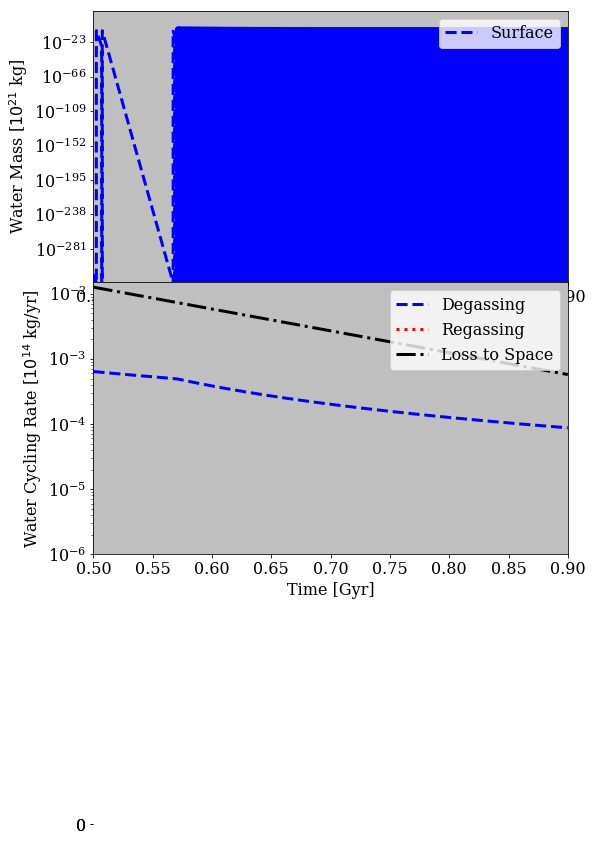

In [212]:
# Play with the scaling on each axis -- log or linear.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(2,1,1)
#plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogy(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
#plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.5,0.9])
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
#plt.ylim(0.01,0.1)
plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2)
plt.semilogy(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_array_hyb*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogy(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_array_hyb*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogy(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_array_hyb*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 0.018, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 0.018, yerr=0.011, ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 0.002, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
#plt.plot(4.5, 0.002, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.5,0.9])
plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.ylim([1.0e-6,1.5e-2])
plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0.05, 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_hyb_model_cycling_extremeloss_linx_logy.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_loglog.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_mantlezoom.pdf', bbox_inches='tight')

<Figure size 1224x540 with 0 Axes>

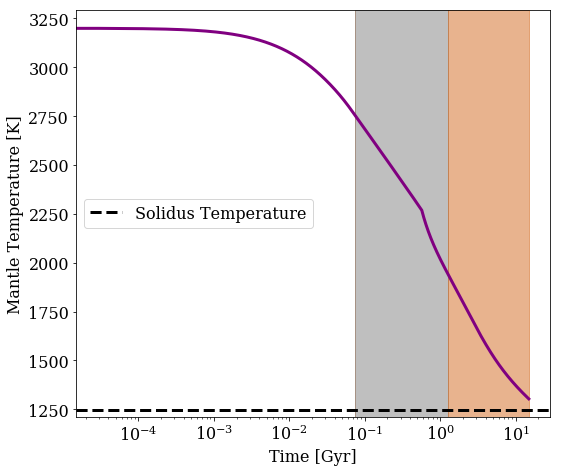

In [40]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_hyb*T_ref, linewidth=3, color='purple')
plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3,label='Solidus Temperature')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.legend(loc='center left', fontsize=16)

#plt.savefig('Recoded_hyb_model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_MantleTemp_extremeloss_shaded.pdf', bbox_inches='tight')

In [303]:
# Calculate wet solidus temperature over time, to be plotted below.

T_sol_wet_array_hyb = np.zeros(len(t_array_hyb))

for idx in range(0,len(t_array_hyb)):
    #Mantle water mass fraction
    x_frac = x_array_hyb[idx]*omega_0*f_btwid/f_M
    #Wet solidus temperature
    T_sol_wet_array_hyb[idx] = T_sol_dry - (K_cnst*x_frac**gamma)

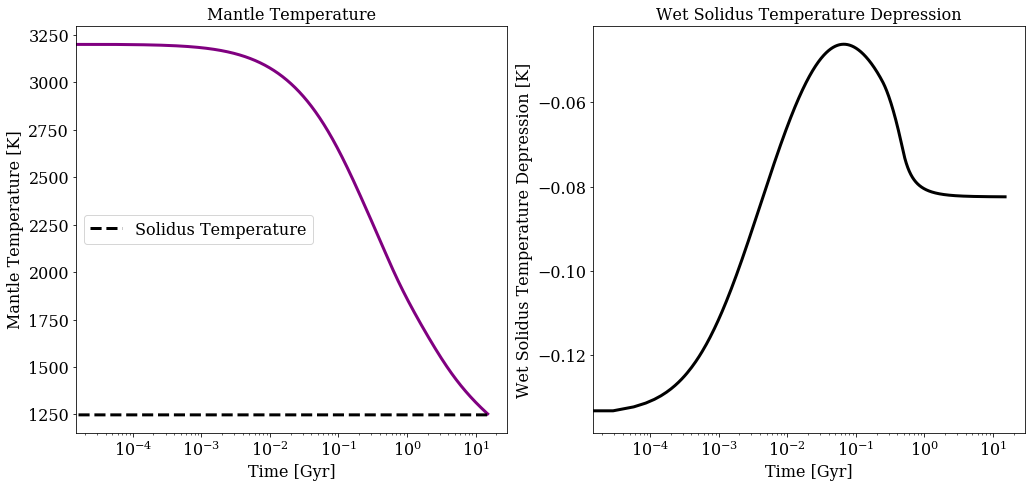

In [304]:
# Same plot as above, but instead of shaded regions, include wet solidus as a function of time, given current x.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()

plt.subplot(121)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, T_array_hyb*T_ref, linewidth=3, color='purple')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, T_sol_wet_array_hyb, linewidth=3, color='k', linestyle='--', label='Solidus Temperature')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
plt.title('Mantle Temperature', fontsize=16)
plt.legend(loc='center left', fontsize=16)


plt.subplot(122)
#Plot wet solidus temperature as a function of time.
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, T_sol_wet_array_hyb-T_sol_dry, linewidth=3, color='k', linestyle='-', label='Solidus Temperature')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Wet Solidus Temperature Depression [K]', fontsize=16)
#plt.xlim([0.05,2])
#plt.ylim([np.min(T_sol_wet_array_hyb), np.max(T_sol_wet_array_hyb)])
#plt.legend(loc='center left', fontsize=16)
plt.title('Wet Solidus Temperature Depression', fontsize=16)

#plt.savefig('Recoded_hyb_model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_MantleTemp_exploss_wetsolidus.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_MantleTemp_extremeloss_wetsolidus.pdf', bbox_inches='tight')

In [305]:
print(T_array_hyb[-1]*T_ref)
print(T_sol_wet_array_hyb[-1])

1253.1719353971885
1248.067594004242


## Plot of mantle overturn timescale as planet evolves.

In [212]:
tau_over_adv_array = np.zeros(len(t_array_hyb))

for idx in range(0,len(t_array_hyb)):
    
    tau_over_adv_array[idx] = tau_over_adv(T_array_hyb[idx], x_array_hyb[idx], M_E, params1, params2, params3)

In [213]:
tau_over_conv_array = np.zeros(len(t_array_hyb))

for idx in range(0,len(t_array_hyb)):
    
    tau_over_conv_array[idx] = tau_over_conv(T_array_hyb[idx], M_E, params1, params2, params3)

Text(0.5, 1.0, 'Convective Overturn Time')

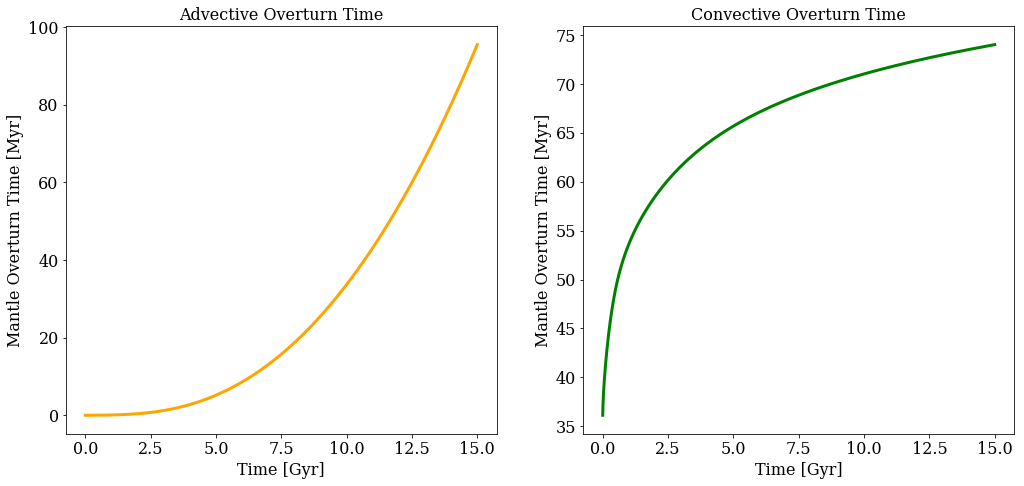

In [218]:
# Plot advective overturn in first panel, convective overturn in second panel.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()

plt.subplot(121)
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, tau_over_adv_array/year/1.0e6, linewidth=3, color='orange')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Overturn Time [Myr]', fontsize=16)
plt.title('Advective Overturn Time', fontsize=16)

plt.subplot(122)
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, tau_over_conv_array/year/1.0e6, linewidth=3, color='green')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Overturn Time [Myr]', fontsize=16)
plt.title('Convective Overturn Time', fontsize=16)

In [49]:
print(T_sol_wet_array_hyb[0:4])
print(T_sol_dry)
print(K_cnst)

[1248.01584464 1248.01680813 1248.01774277 1248.01865017]
1248.15
43.0


In [449]:
print(1.0/tau(M_E,params1,params2,params3)/year/1.0e9)

2.8732400081113805


In [ ]:
print(omegatwid*omega_0*f_btwid)

# Alternate Hybrid Model
## Once mantle cools below solidus temperature, plate tectonics stop --> BOTH regassing and degassing shut off, locking-in the water inventories at that time (albeit with a small amount of loss occurring)

In [16]:
# Many functions have already been defined for the SS model -- only define new things here.

def Etwid(M,params1,params2,params3,params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/D(M,params1,params2,params3,params4)

def Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

In [24]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.
def f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
            
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif s_twid <= 0.:
                 dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
                    
        else: #mantle temperature below solidus, degassing AND regassing shut off
            
            # No need for hydrated layer check here
            dx_twid = 0. - 0.
                
        #Mantle water capacity check        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif s_twid <= 0.:
                dx_twid = 0. - 0.
                
        else: # mantle temperature below solidus, regassing AND degassing shut off
            
            dx_twid = 0. - 0.
                
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        #Degassing check from CA2014 (only one option for degas though) + solidus temperature check
        
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        else: #mantle temperature below solidus, degassing AND regassing shut off
            dx_twid = 0. - 0.
        
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # This can either turn loss off, or change the loss rate.
    loss_factor = 0. #no loss
    #leave loss_factor as is -- exponential loss
    #loss_factor = 10.*loss_factor # EXTREME loss
        
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
            
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = dg_hyb - \
                    (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = dg_hyb - \
                    (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
                
        else: #mantle temperature below solidus, degassing AND regassing shuts off
            
            # No need for hydrated layer check here
            if s_twid > 0.: 
                ds_twid = 0. - 0. \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0.:
                ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = 0. - (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = 0. - (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0.:
                ds_twid = 0. - 0. - 0.
                
        else: #mantle temperature below solidus, degassing AND regassing shuts off
            
            # No need for hydrated layer check here
            if s_twid > 0.: 
                ds_twid = 0. - 0. \
                    - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0.:
                ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
        else: #mantle temperature below solidus, degassing AND regassing shut off
            ds_twid = 0. - 0. - 0.
        
        # Surface water capacity check
        if s_twid + (ds_twid*dt) <= (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) > (50*1.4e21/M_E/(omega_0*f_btwid)):
            return ((50*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_hyb(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]
    

In [25]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # Solidus temperature check
    if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling

        if s_twid > 0.:
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
            elif s_twid <= 0.:
                 return 0.
            
        elif s_twid <= 0.:
            return 0.
        
    else: #mantle temperature below solidus; regassing shuts off
        
        return 0.
    
def f_degas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # Solidus temperature check
    if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling

        # Degassing check from CA2014
        if x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE): #normal degassing
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        elif x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) >= (1./f_degasE):
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        elif x_twid > 0. and s_twid <= 0.:
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        else: #if x_twid <= 0. OR s_twid <=0 ; no degassing --> depends on seafloor pressure, no water = no pressure
            return 0.
        
    else: #mantle temperature below solidus, degassing shuts off
        return 0.
    
def f_loss_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # This can either turn loss off, or change the loss rate.
    loss_factor = 0. #no loss
    #leave loss_factor as is -- exponential loss
    #loss_factor = 10.*loss_factor #EXTREME loss

    #if s_twid > 0.: #normal loss
    return (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
    #elif s_twid <= 0.: #no loss
    #    return 0.

In [26]:
def omega_hydr_twid_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)  

In [27]:
# Set initial conditions.
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
#z0 = [2., 1.4e21/M_E/(omega_0*f_btwid), 50.*1.4e21/M_E/(omega_0*f_btwid)]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_hyb).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 5.22 #cycling rate over tau instead of tau_SS? If not -->#6.76 #~15 Gyr #100.
dt = 1.e-5
t_array_hyb = np.zeros(int(t1/dt)+1)
T_array_hyb = np.zeros(int(t1/dt)+1)
x_array_hyb = np.zeros(int(t1/dt)+1)
s_array_hyb = np.zeros(int(t1/dt)+1)
regas_array_hyb = np.zeros(int(t1/dt)+1)
degas_array_hyb = np.zeros(int(t1/dt)+1)
loss_array_hyb = np.zeros(int(t1/dt)+1)
omega_hydr_array_hyb = np.zeros(int(t1/dt)+1)
#eta_array_CA = np.zeros(int(t1/dt))

# Initial values in the arrays.
t_array_hyb[0] = t0
T_array_hyb[0] = z0[0]
x_array_hyb[0] = z0[1]
s_array_hyb[0] = z0[2]
regas_array_hyb[0] = f_regas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
degas_array_hyb[0] = f_degas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
loss_array_hyb[0] = f_loss_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
omega_hydr_array_hyb[0] = omega_hydr_twid_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)

# Integrate the above function.
idx = 1
#while r.successful() and r.t < t1:

start_time = time.time()

for idx in range(1,len(t_array_hyb)):
    
    if r.successful() == True:
        r.integrate(r.t+dt)
        t_array_hyb[idx] = r.t
        T_array_hyb[idx] = r.y[0]
        x_array_hyb[idx] = r.y[1]
        s_array_hyb[idx] = r.y[2]
        regas_array_hyb[idx] = f_regas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        degas_array_hyb[idx] = f_degas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        loss_array_hyb[idx] = f_loss_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
    
    elif r.successful() == False:
        
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
        t_array_hyb[idx] = t_array_hyb[idx-1] + dt
        
        T_array_hyb[idx] = T_array_hyb[idx-1] + \
            f_delta_temp_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        x_array_hyb[idx] = x_array_hyb[idx-1] + \
            f_delta_x_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        s_array_hyb[idx] = s_array_hyb[idx-1] + \
            f_delta_s_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        
        regas_array_hyb[idx] = f_regas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        degas_array_hyb[idx] = f_degas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        loss_array_hyb[idx] = f_loss_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        
        # Leave the loop if both reservoirs have zero water.
        if x_array_hyb[idx] <= 0. and s_array_hyb[idx] <= 0.:
            break
    
    #idx = idx + 1
    
end_time = time.time()
print(end_time-start_time, ' s')
    
# Mass of water in hydrated layer
M_hydr_hyb = omega_hydr_array_hyb*2.3e-4*1.3*M_E #[kg]

159.23187899589539  s


In [28]:
# Mark where surface becomes desiccated, then where it begins recovering.
tolerance = 1.29e16/(2.3e-4*1.3*M_E)

dune_first_idx_hyb = -1
for ldx in range(0,len(s_array_hyb)):
    if s_array_hyb[ldx] <= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
        dune_first_idx_hyb = ldx
        break

desiccated_idx_hyb = -1
if dune_first_idx_hyb >= 0:
    for idx in range(dune_first_idx_hyb+1,len(s_array_hyb)):
        if s_array_hyb[idx] <= tolerance:
            desiccated_idx_hyb = idx
            break
        
recover_idx_hyb = -1
if desiccated_idx_hyb >= 0:
    for jdx in range(desiccated_idx_hyb+1,len(s_array_hyb)):
        if s_array_hyb[jdx] >= tolerance:
            recover_idx_hyb = jdx
            break
                     
dune_idx_hyb = -1
if recover_idx_hyb >= 0:
    for kdx in range(recover_idx_hyb+1,len(s_array_hyb)):
        if s_array_hyb[kdx] >= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
            dune_idx_hyb = kdx
            break
            
print(desiccated_idx_hyb, recover_idx_hyb)

-1 -1


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


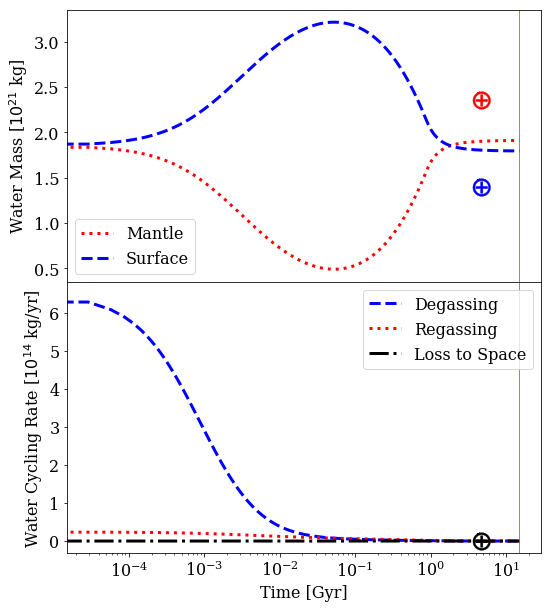

In [29]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(2,1,1)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_array_hyb*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_array_hyb*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_array_hyb*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 0.018, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 0.018, yerr=0.011, ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 0.002, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
plt.plot(4.5, 0.002, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0.05, 1.0), ncol=2, fontsize=16)

#plt.savefig('Recoded_hyb_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_xlimit.pdf', bbox_inches='tight')

In [31]:
print(x_array_hyb[-5:-1])
print(s_array_hyb[-5:-1])
print(degas_array_hyb[-5:-1])
print(regas_array_hyb[-5:-1])

[1.06869874 1.06869874 1.06869874 1.06869874]
[1.00487986 1.00487986 1.00487986 1.00487986]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
